# Application of Deep Knockoffs for Functional Magnetic Resonance Imaging to Generate Surrogate Data

This notebook describes the pipeline to follow to build Knockoffs from fMRI images. These knockoffs generate surrogate data that is used in non-parametric tests to obtain a Statistical Parametric Map (SPM) of the brain.

First of all, some things to consider:
* fMRI images data set we use in this work was made available by the Medical Image Processing Laboratory (MIPLAB) 
* The Knockoff library can be found at https://github.com/msesia/deepknockoffs.git


## Structure
The process is divided into 4 main parts, which consist of:
#### 1. Performing the **General Linear Model (GLM)** on the data
This is the classical method to obtain the SPM, which returns the fitted beta values for $$ y = X\beta$$ where y is the fMRI timecourse and X is the design matrix of the experiment.


#### 2. Generating Knockoffs
Given the data, the algorithm will build a machine to generate surrogate timecourses. 
There are three methods:
* Gaussian Knockoffs
* Low Rank Knockoffs
* Deep Knockoffs
    
    
#### 3. Performing **Non-Parametric Tests**
The GLM is applied to the generated surrogate data to get the beta values and these are used to threshold the true betas using Non-Parametric Tests, which can be:
* Uncorrected Non-Parametric Test
* Corrected Non-Parametric Test
    
#### 4. Visualizing the results
* Brain plot (Matlab)
* Confusion matrix




In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

from implementation import glm, knockoff_class, params
from implementation.load import load_pickle, load_fmri
from implementation.utils import KNOCK_DIR, compare_diagnostics

## 1. GLM

In [4]:
# running the GLM on all tasks
glm.run()

 MOTOR 
Loading data for task MOTOR...
Loaded Data - Shape: (100, 379, 284)
Loaded Task Paradigms - Shape: (100, 284)
Computing GLM for task MOTOR...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task MOTOR...
 GAMBLING 
Loading data for task GAMBLING...
Loaded Data - Shape: (100, 379, 253)
Loaded Task Paradigms - Shape: (100, 253)
Computing GLM for task GAMBLING...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task GAMBLING...
 RELATIONAL 
Loading data for task RELATIONAL...
Loaded Data - Shape: (100, 379, 232)
Loaded Task Paradigms - Shape: (100, 232)
Computing GLM for task RELATIONAL...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task RELATIONAL...
 SOCIAL 
Loading data for task SOCIAL...
Loa

## 2. Building Knockoffs

In [14]:
# selecting the same task and subject as in the report
task = 'MOTOR'
subject = 1

# loading all the data
fmri_data = load_fmri(task=task)

Loaded Data - Shape: (100, 379, 284)


### a) Gaussian Knockoffs

Loaded Data - Shape: (100, 379, 284)
Divided 379 variables into 154 groups.
Divided 379 variables into 154 groups.
Size of largest groups: 37
Mean groups size: 2.461038961038961
Eigenvalue for Sigma Hat, Min: -2.254258744564657e-15
Eigenvalue for Sigma Hat Representatives, Min: 0.0436073458894031
Original for Correlations, Max: 0.8022580778679829
Representatives for Correlations, Max: 0.4585931438028127
Average absolute pairwise correlation: 0.859.


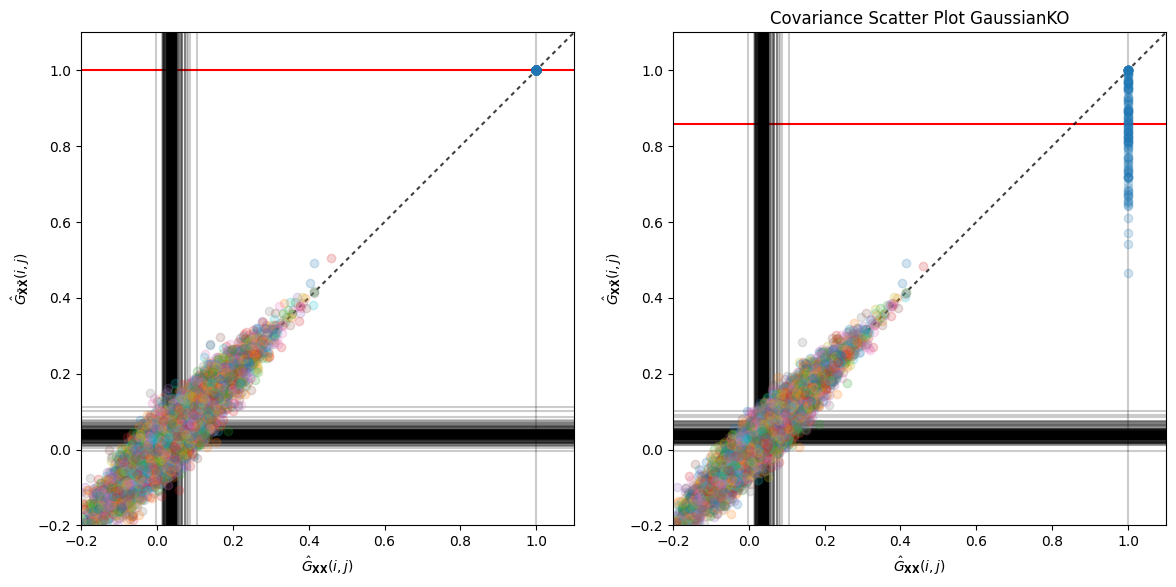

                               Value                                     \
                               count        mean        std         min   
Method     Metric     Swap                                                
GaussianKO Covariance full     100.0  232.275747  13.434481  195.189874   
                      partial  100.0  257.455406  13.739929  217.971834   
                      self     100.0    0.858811   0.001028    0.855988   
           Energy     full     100.0    0.307741   0.005598    0.293565   
                      partial  100.0    0.308905   0.005566    0.293409   
           KNN        full     100.0    0.645880   0.024102    0.591549   
                      partial  100.0    0.658732   0.024296    0.605634   
           MMD        full     100.0   -0.001916   0.000327   -0.002758   
                      partial  100.0   -0.001799   0.000331   -0.002852   

                                                                               
                   

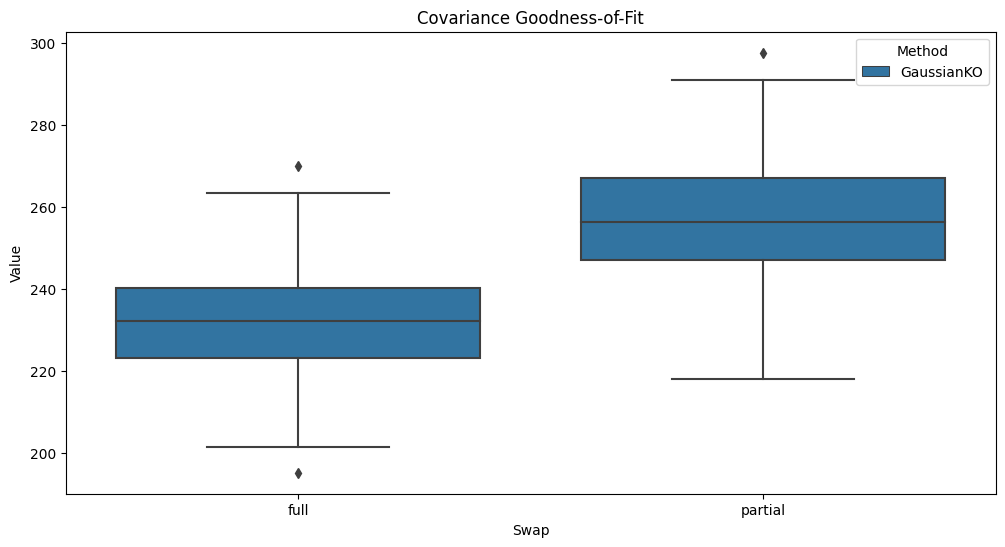

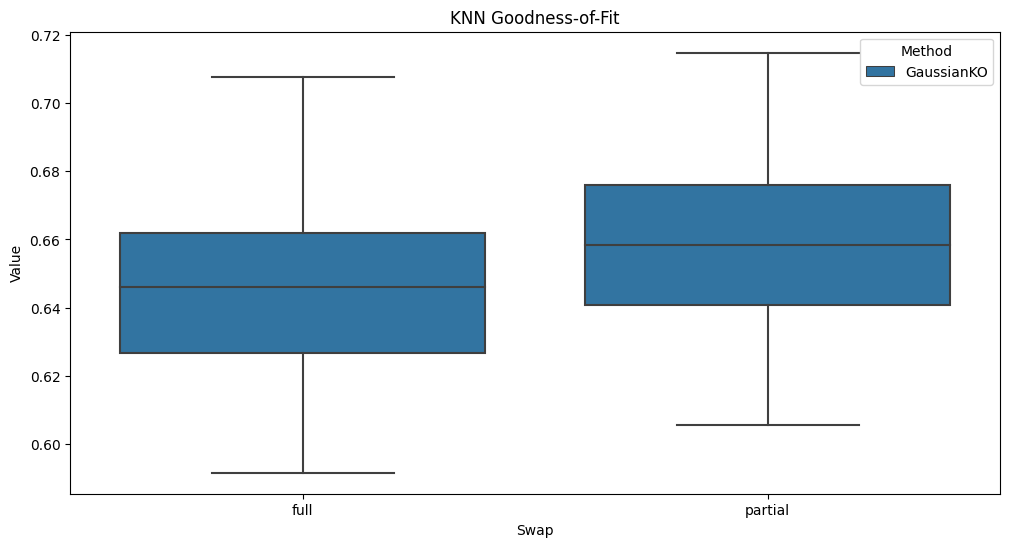

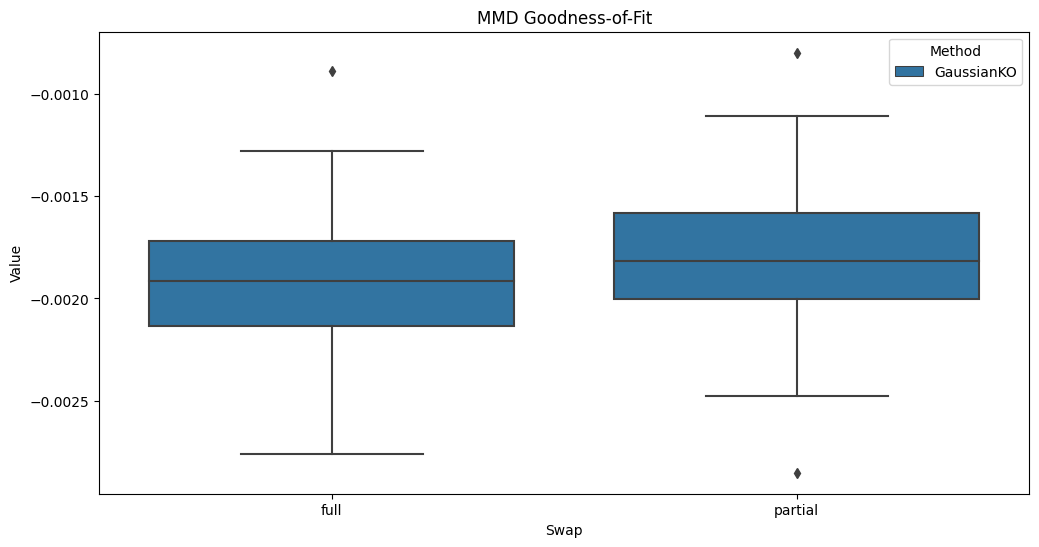

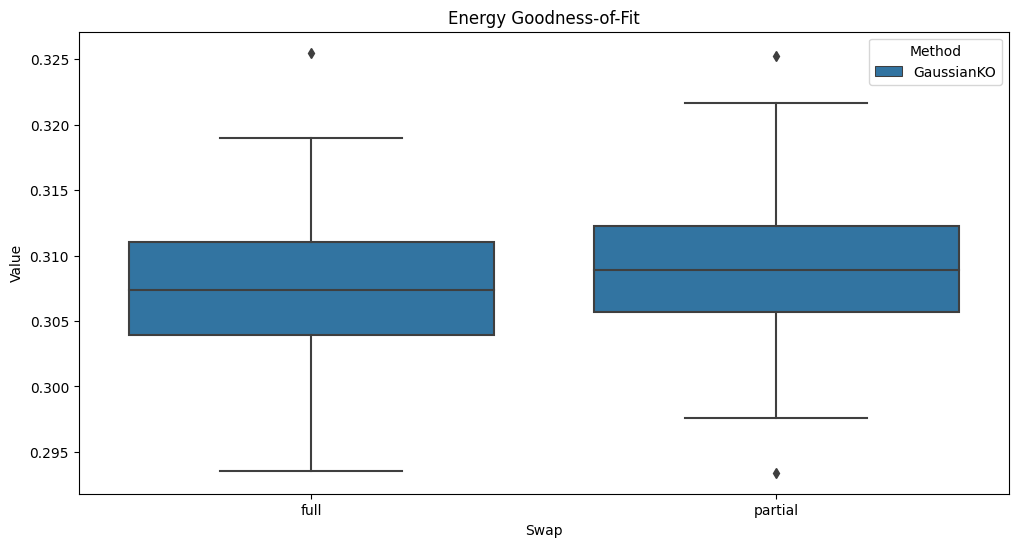

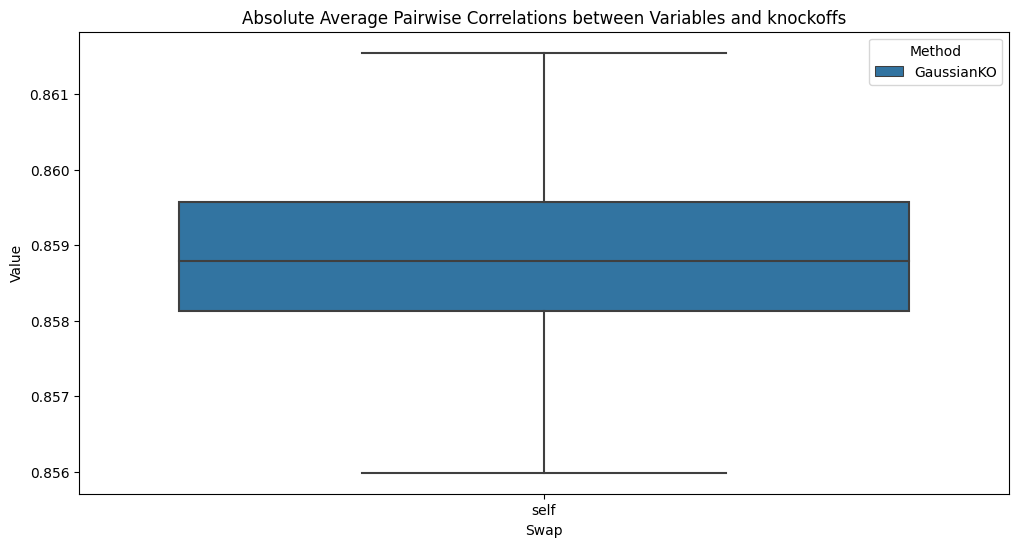

In [15]:
gaussian = knockoff_class.GaussianKnockOff(task, subject)  

gaussian.load_fmri()

# Pre-processing the data: clustering to decrease correlations
gaussian.pre_process(max_corr=.3)

# Training the machine to build second-order knockoffs
_ = gaussian.fit() 

# Plotting diagnostics to show the performance of the knockoffs
res_gaus = gaussian.diagnostics()

In [16]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
data_gaussian = gaussian.transform()
print(data_gaussian.shape)

(101, 284, 379)


### b) Low Rank Knockoffs

Loaded Data - Shape: (100, 379, 284)


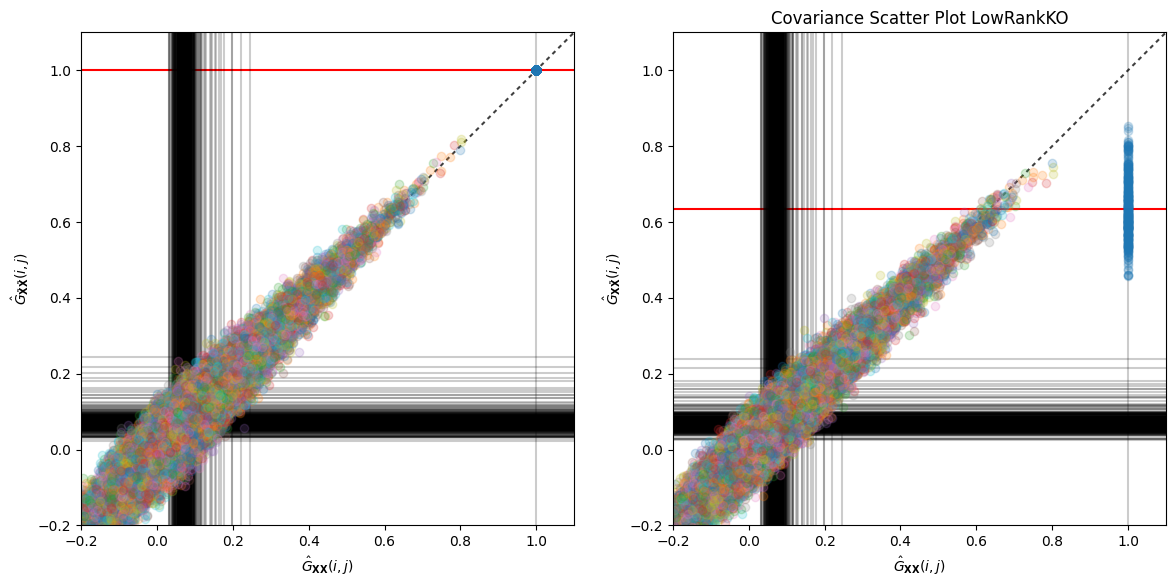

                              Value                                        \
                              count         mean         std          min   
Method    Metric     Swap                                                   
LowRankKO Covariance full     100.0  4065.077021  201.358006  3448.026293   
                     partial  100.0  4616.425170  203.709341  3999.147225   
                     self     100.0     0.634350    0.001393     0.631330   
          Energy     full     100.0     0.580778    0.014594     0.547760   
                     partial  100.0     0.586949    0.014540     0.556134   
          KNN        full     100.0     0.850810    0.016253     0.816901   
                     partial  100.0     0.876831    0.014548     0.841549   
          MMD        full     100.0     0.002757    0.000550     0.001524   
                     partial  100.0     0.003187    0.000545     0.002095   

                                                                     \
    

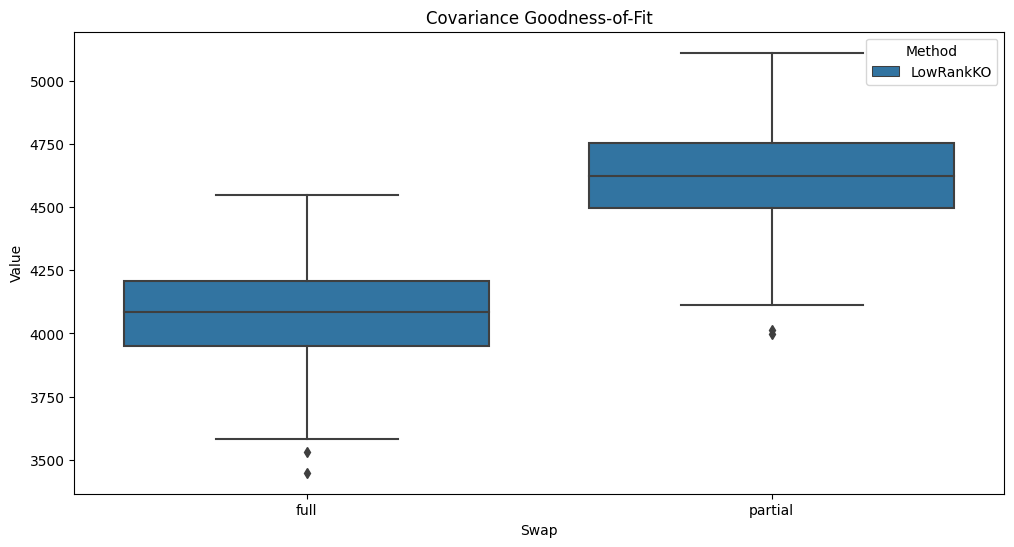

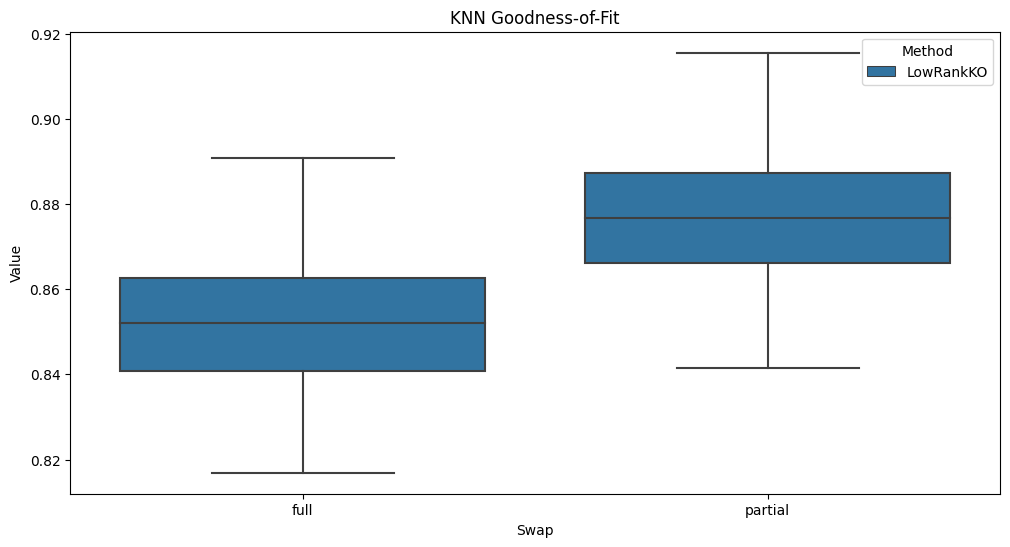

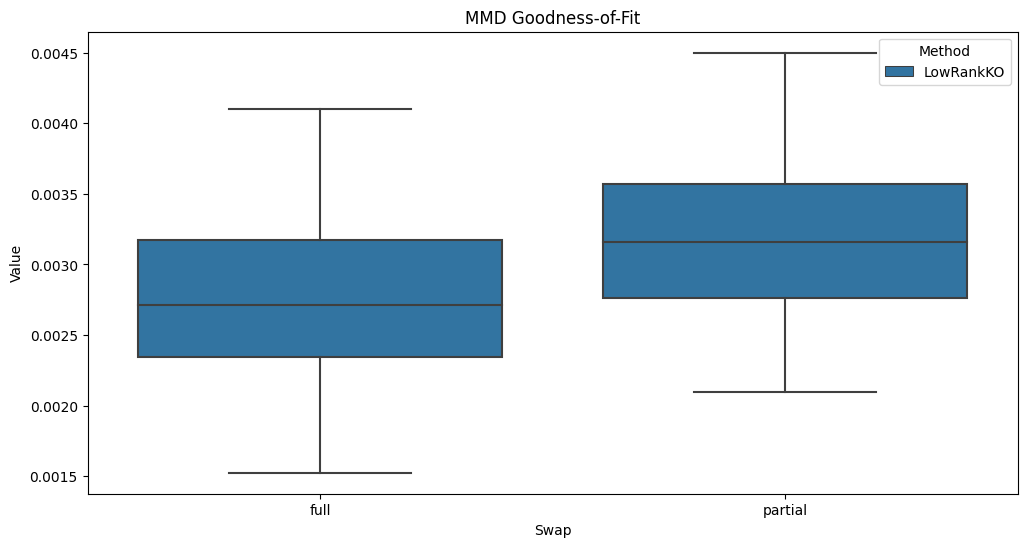

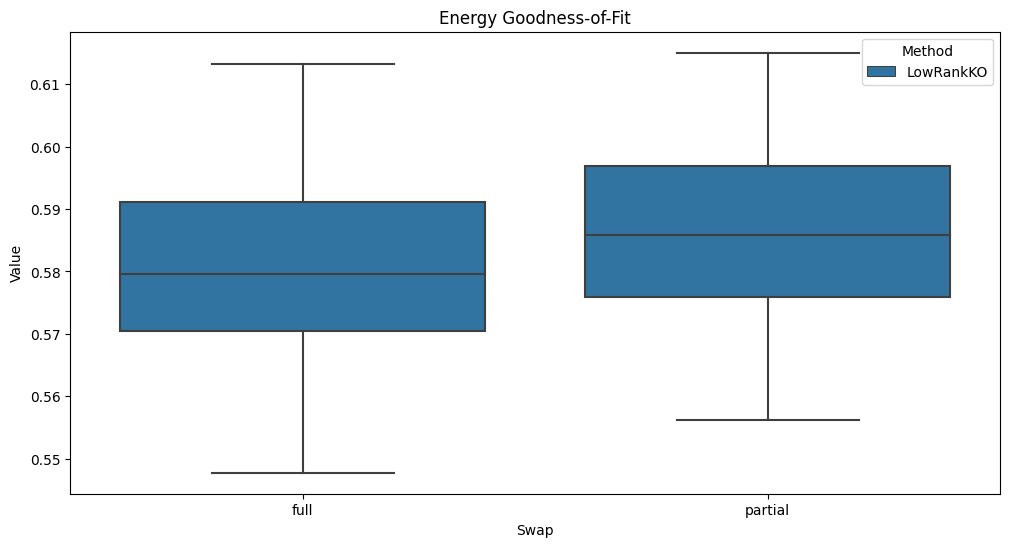

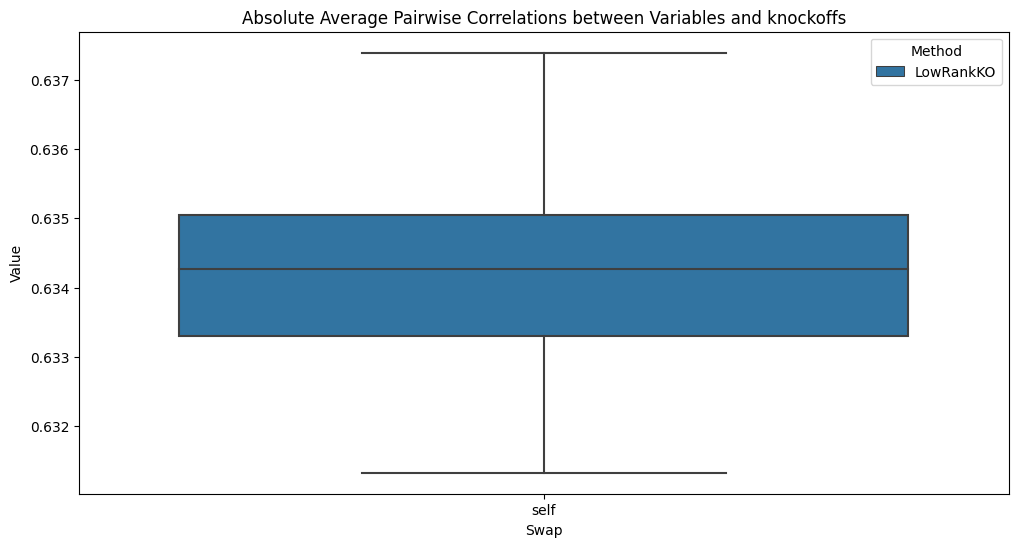

In [17]:
lowrank = knockoff_class.LowRankKnockOff(task, subject)  

lowrank.load_fmri()

# Training the machine to build low-ranked knockoffs
_ = lowrank.fit(rank=120) 

# Plotting diagnostics to show the performance of the knockoffs
res_lowrank = lowrank.diagnostics()

In [18]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
data_lowrank = lowrank.transform()
print(data_lowrank.shape)

(101, 284, 379)


### c) Deep Knockoffs

We can load a previously trained machine or train a new one.

* **Loading a machine**

Loaded Data - Shape: (100, 379, 284)
Divided 379 variables into 154 groups.
Divided 379 variables into 154 groups.
Size of largest groups: 37
Mean groups size: 2.461038961038961
Eigenvalue for Sigma Hat, Min: -2.254258744564657e-15
Eigenvalue for Sigma Hat Representatives, Min: 0.0436073458894031
Original for Correlations, Max: 0.8022580778679829
Representatives for Correlations, Max: 0.4585931438028127
Saving file GaussianKO_tfMRI_tMOTOR_s1_c0.3.pickle
Saving file GaussianKO_mapping_tMOTOR_s1_c0.3.pickle
Average absolute pairwise correlation: 0.859.
Saving file DeepKO_tMOTOR_s1_params
=> loading checkpoint '/home/alex/Documents/epfl/machine_learning/machine-learning-cs433-p2/data/output/knockoffs/DeepKO_tMOTOR_s1_checkpoint.pth.tar'
=> loaded checkpoint '/home/alex/Documents/epfl/machine_learning/machine-learning-cs433-p2/data/output/knockoffs/DeepKO_tMOTOR_s1_checkpoint.pth.tar' (epoch 5)


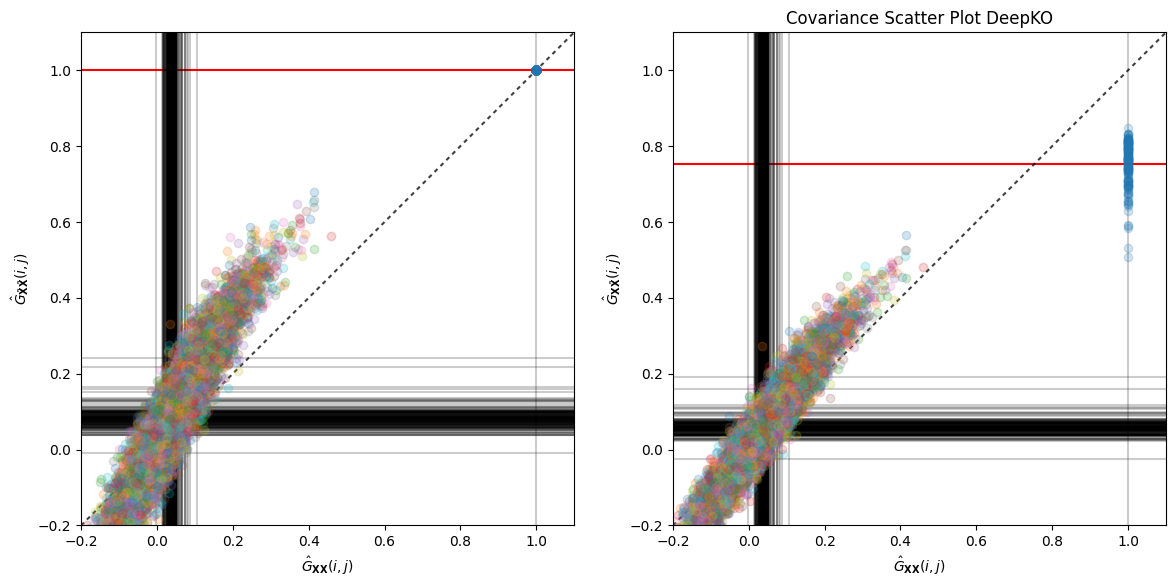

                           Value                                    \
                           count        mean       std         min   
Method Metric     Swap                                               
DeepKO Covariance full     100.0  195.068573  8.564863  171.033753   
                  partial  100.0  196.472629  8.270844  174.510583   
                  self     100.0    0.751717  0.001238    0.748628   
       Energy     full     100.0    0.273619  0.004883    0.258706   
                  partial  100.0    0.275096  0.004689    0.261778   
       KNN        full     100.0    0.710493  0.021035    0.637324   
                  partial  100.0    0.702465  0.018460    0.658451   
       MMD        full     100.0   -0.000687  0.000337   -0.001777   
                  partial  100.0   -0.000580  0.000328   -0.001605   

                                                                           
                                  25%         50%         75%         max  
Method 

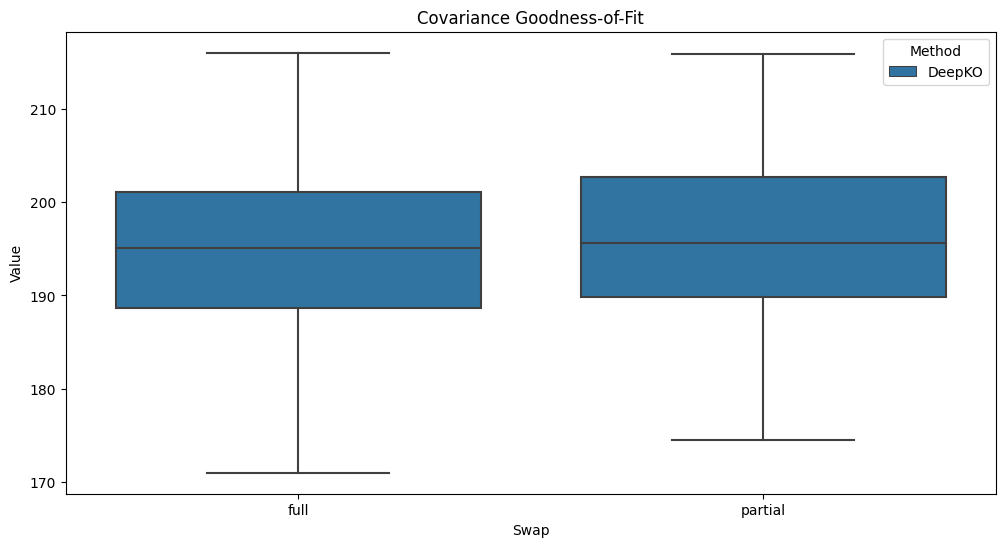

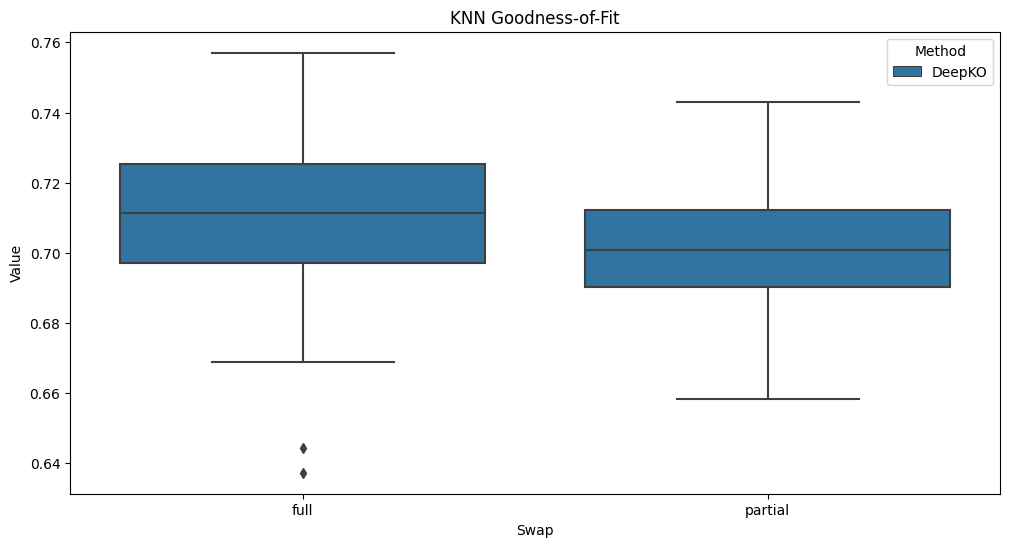

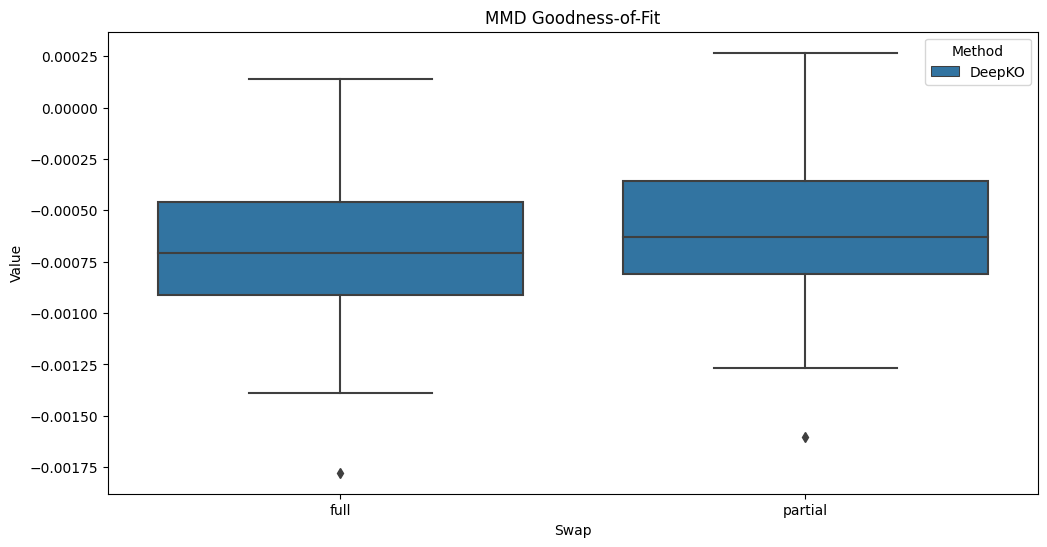

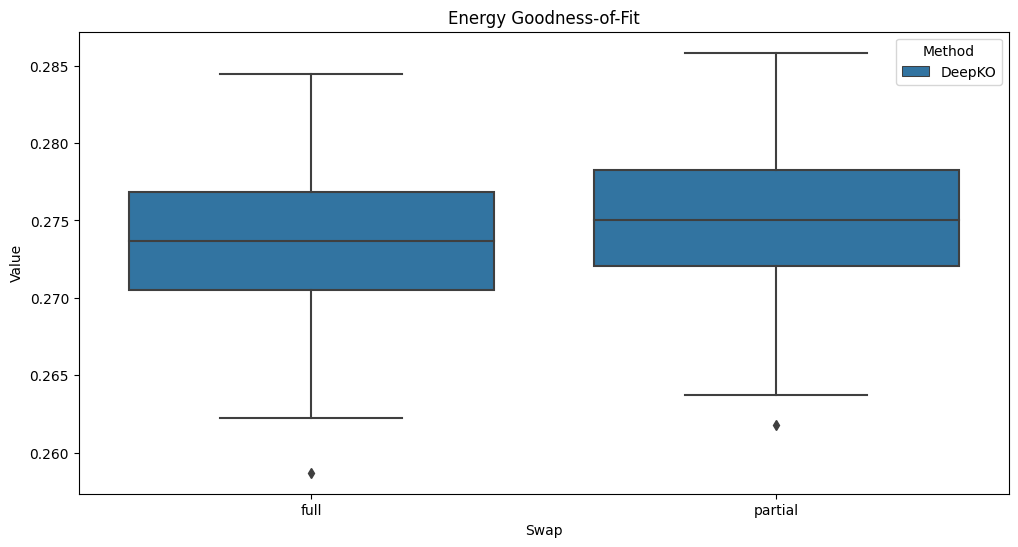

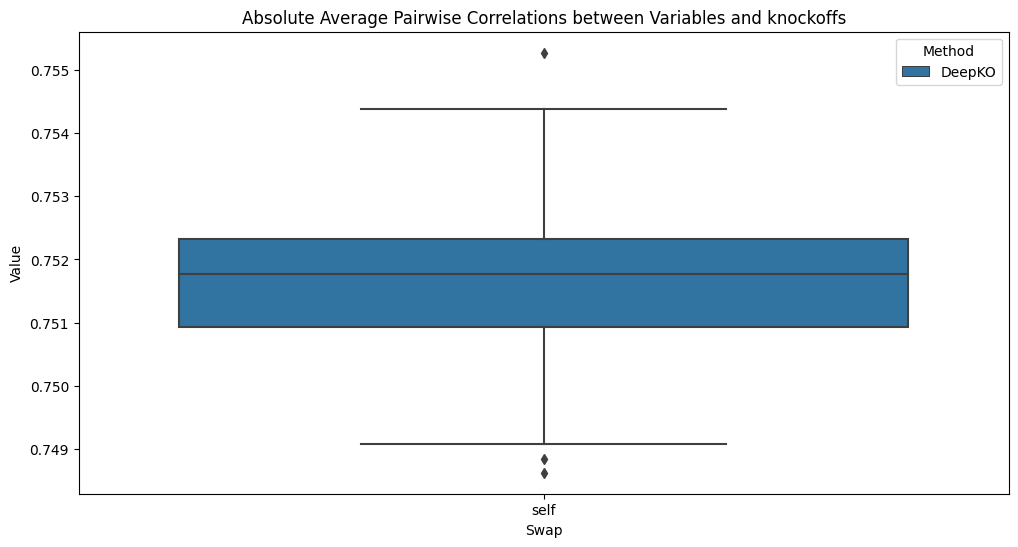

In [19]:
# We can load a previously trained machine
deepko = knockoff_class.DeepKnockOff(task, subject)
deepko.pre_process(max_corr=.3, save=True)

# Loading previously trained machine
_, x_train = load_pickle(KNOCK_DIR, f'GaussianKO_tfMRI_t{task}_s{subject}_c0.3.pickle')
groups, _ = load_pickle(KNOCK_DIR, f'GaussianKO_mapping_t{task}_s{subject}_c0.3.pickle')
params = load_pickle(KNOCK_DIR, f'DeepKO_tMOTOR_s{subject}_params')

deepko.load_x(x_train)
deepko.load_params(params)
deepko.load_machine()

res_deepko = deepko.diagnostics()

In [20]:
data_deepko = deepko.transform(groups=groups)

deepko_betas = deepko.statistic(data_deepko, save=True)
uncorrected_betas_deepko, corrected_betas_deepko = deepko.threshold(deepko_betas, save=True)

Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tMOTOR_s1.mat
Saving file DeepKO_corrected_betas_tMOTOR_s1.mat


* **Training a new machine (Takes several hours 🥵🥵🥵)**

In [ ]:
# Or train a new knockoff machine
deepko = knockoff_class.DeepKnockOff(task, subject)  

# Pre-processing the data: clustering to avoid correlations
deepko.pre_process(max_corr=.3, save=True)

# Training the machine to build second-order knockoffs. The parameters can be changed at params.py
_ = deepko.fit() 

# Plotting diagnostics to show the performance of the knockoffs
res_deepko = deepko.diagnostics()

In [21]:
# generating deep knockoffs
data_deepko = deepko.transform(groups=groups)
# calculating the GLM betas for the knockoffs
deepko_betas = deepko.statistic(data_deepko, save=True)
# executing the non-parametric test
uncorrected_betas_deepko, corrected_betas_deepko = deepko.threshold(deepko_betas, save=True)

Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tMOTOR_s1.mat
Saving file DeepKO_corrected_betas_tMOTOR_s1.mat


In [22]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
deepko.transform()
print(data_deepko.shape)

(101, 284, 379)


## Comparing the knockoff diagnostics

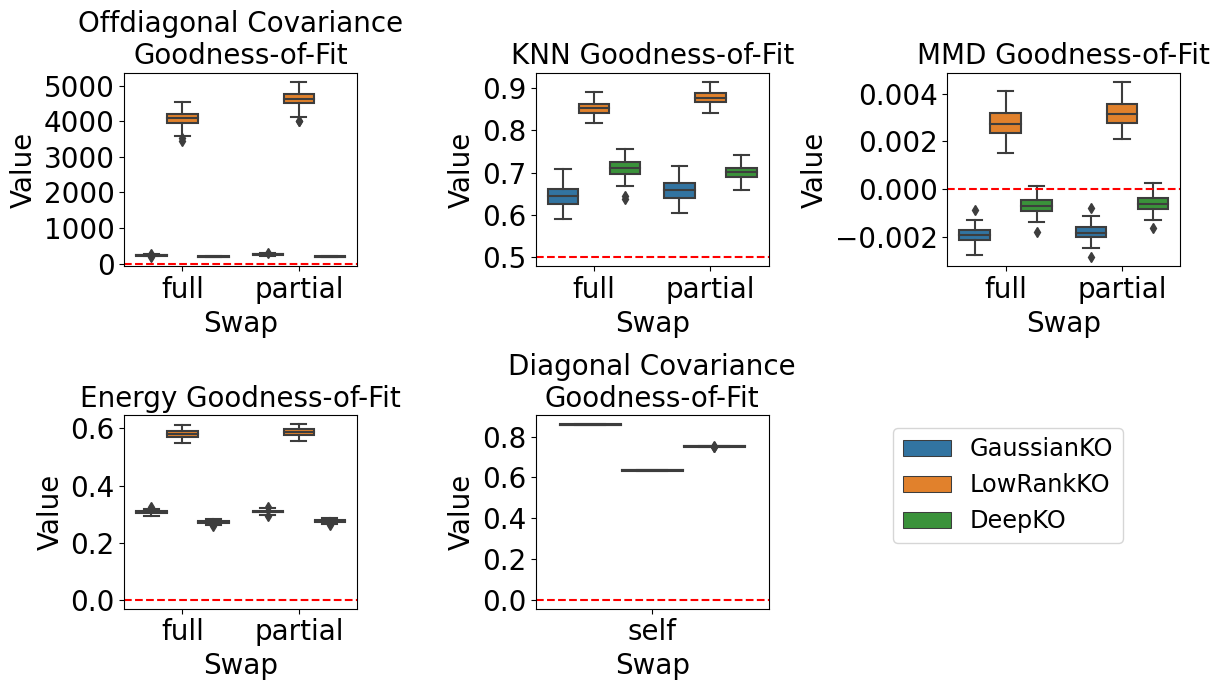

In [23]:
# comparing the diagnostics for the knockoffs
res_total = pd.concat([res_gaus, res_lowrank, res_deepko], ignore_index=True, sort=False)
compare_diagnostics(res_total)

## 3. Non-Parametric tests

In [30]:
# Computing the beta values of the knockoffs
gaussian_betas = gaussian.statistic(data_gaussian, save=True)
lowrank_betas = lowrank.statistic(data_lowrank, save=True)
deepko_betas = deepko.statistic(data_deepko, save=True)

Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file GaussianKO_KObetas_tMOTOR_s1.mat
Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file LowRankKO_KObetas_tMOTOR_s1.mat
Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tMOTOR_s1.mat


In [25]:
# Performing corrected and uncorrected Non-Parametric tests to threshold
uncorrected_betas_gaussian, corrected_betas_gaussian = gaussian.threshold(gaussian_betas, save=True)
uncorrected_betas_lowrank, corrected_betas_lowrank = lowrank.threshold(lowrank_betas, save=True)
uncorrected_betas_deepko, corrected_betas_deepko = deepko.threshold(deepko_betas, save=True)

Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file GaussianKO_uncorrected_betas_tMOTOR_s1.mat
Saving file GaussianKO_corrected_betas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file LowRankKO_uncorrected_betas_tMOTOR_s1.mat
Saving file LowRankKO_corrected_betas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tMOTOR_s1.mat
Saving file DeepKO_corrected_betas_tMOTOR_s1.mat


## 4. Visualizing our results
The results can either be visualized in Matlab using the script `PlotGraph/our_plots.m`, which will show a brain plot with the activation regions; or by a confusion matrix, which gives a comparison on the active regions of the brain for each method compared to the GLM.

In [27]:
# "true" betas computed with GLM
TRUE_BETAS = f'./data/output/beta/GLM_betas_{task}.mat'
# "true" controlled betas computed with GLM
TRUE_BETAS_CONTROLLED = f'./data/output/beta/GLM_controlled_betas_{task}.mat'
# "true" uncontrolled betas computed with GLM
TRUE_BETAS_UNCONTROLLED = f'./data/output/beta/GLM_uncontrolled_betas_{task}.mat'

true_betas = scipy.io.loadmat(TRUE_BETAS)['beta'][subject, :, :]  
true_betas_controlled = scipy.io.loadmat(TRUE_BETAS_CONTROLLED)['beta'][subject, :, :]  
true_betas_uncontrolled = scipy.io.loadmat(TRUE_BETAS_UNCONTROLLED)['beta'][subject, :, :] 

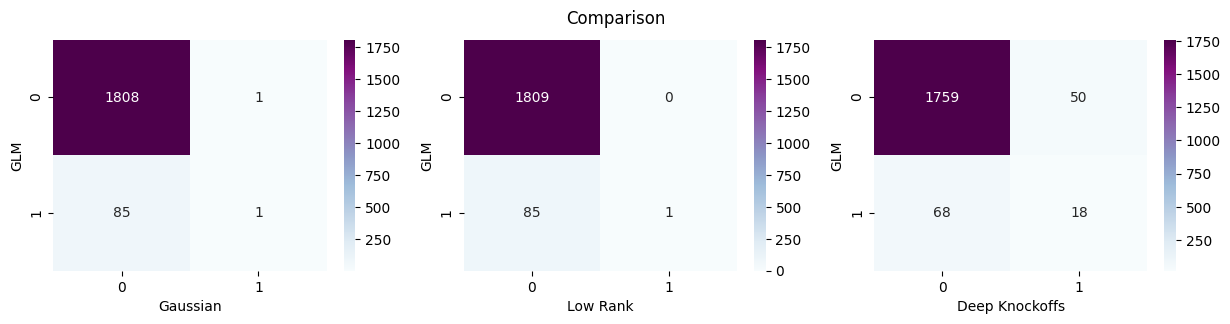

In [29]:
def plot_confusion_matrix(true, methods, true_label, methods_labels):
    """
    Plots the confusion matrices given in the report.
    true: "true" GLM labels
    methods: betas to compare to the "true" GLM labels
    true_labels: label for the "true" beta values
    methods_labels: labels for the compared beta values    
    """
    true = [0 if x == 0 else 1 for x in true.ravel()]

    fig, axes = plt.subplots(1, len(methods), figsize=(15,3))
    fig.suptitle('Comparison')
    
    for idx, method in enumerate(methods):
        method = [0 if x == 0 else 1 for x in method.ravel()]
        data = {true_label:    true,
        methods_labels[idx]: method
        }

        df = pd.DataFrame(data, columns=[true_label, methods_labels[idx]])

        confusion_matrix = pd.crosstab(df[true_label], df[methods_labels[idx]], rownames=[true_label], 
                                       colnames=[methods_labels[idx]], margins=False)
    
        sns.heatmap(confusion_matrix, ax=axes[idx], annot=True, cmap = 'BuPu',fmt='g')
    
    plt.show()

true = true_betas_controlled
methods = [corrected_betas_gaussian, corrected_betas_lowrank, corrected_betas_deepko]
methods_labels = ['Gaussian', 'Low Rank', 'Deep Knockoffs']
true_label = 'GLM'
plot_confusion_matrix(true, methods, true_label, methods_labels)    

A sample brain plot:
<img src="data/output/img/DeepKO_corrected_betas_tMOTOR_s1_cond2.png">